In [2]:
# General Libraries
import numpy as np
from tdmclient import ClientAsync
import time
import matplotlib.pyplot as plt

# Custom libraries 
from src.Filtering import filtering
from src.Filtering import local_navigation as ln
from src.Motion_Control import thymio as th

client = ClientAsync()
node = await client.wait_for_node()
await node.lock()

Node 57eefc4f-0e49-4eba-b33e-341c5f84b956

In [3]:
import numpy as np

# Point final/goal
goal = np.array([[200], [200], [0]])

# Nombre de points intermédiaires à générer
num_points = 10

# Création d'une séquence de dix points intermédiaires
intermediate_points = []
for i in range(num_points + 1):
    intermediate_x = i * goal[0][0] / num_points
    intermediate_y = i * goal[1][0] / num_points
    intermediate_theta = i * goal[2][0] / num_points

    intermediate_points.append([intermediate_x, intermediate_y, intermediate_theta])

# Conversion en tableau NumPy et transposition
intermediate_points = np.array(intermediate_points).T

# Transformation pour obtenir les composantes x, y, et l'angle en radians
intermediate_points_with_angle = np.vstack((intermediate_points[:2], intermediate_points[2] % (2 * np.pi))).T

# Affichage de chaque checkpoint
for i in range(10):
    print(intermediate_points_with_angle[i])

[0. 0. 0.]
[20. 20.  0.]
[40. 40.  0.]
[60. 60.  0.]
[80. 80.  0.]
[100. 100.   0.]
[120. 120.   0.]
[140. 140.   0.]
[160. 160.   0.]
[180. 180.   0.]


In [4]:
#MAIN CODE : 

THRESHOLD_OBST = 3500 
command_motor = [101, 100]
command_motor_rotate = [-101, 100]
speed_history = []
angular_speed_history = []
norm_distance = []
angle = []
state_x = []
state_y = []
goal = np.array([[20], [20], [0]])
local_obstacle = False

async def main():

    global local_obstacle
    bool_camera = False
    camera_position = np.array([[0], [0], [0]]) # get_camera_position()

    start_time = time.time()
    state_estimation = np.array([[0], [0], [0], [0], [0]])
    P_estimation = np.diag([100, 100, 0.75, 10, 0.75])
    i=0

    while(1):
        
        node = await client.wait_for_node()
        sens = await ln.get_proximity_values(node)

        if (sum(sens[i] > THRESHOLD_OBST for i in range(0, 5)) > 0): local_obstacle = True

        if(local_obstacle):
            node.send_set_variables(ln.motors(0,0))
            break

        if not local_obstacle: 

            # await th.move_to_goal2(client, state_estimation, intermediate_points_with_angle[i], 100)
            # print("next checkpoint")
            # i += 1
            # state_estimation, P_estimation, speed, angular_speed, start_time = await filtering.get_position(state_estimation, P_estimation, start_time, bool_camera, camera_position, node)
            # if np.sqrt((state_estimation[0] - intermediate_points_with_angle[-1][0])**2 + (state_estimation[1] - intermediate_points[-1][1])**2) < 10:
            #     node.send_set_variables(ln.motors(0,0))
            #     break
            if state_estimation[0] < 200 and state_estimation[2] < np.pi/2:
                node.send_set_variables(ln.motors(command_motor[0], command_motor[1]))
                #node.send_set_variables(ln.motors(command_motor_rotate[0], command_motor_rotate[1]))
                state_estimation, P_estimation, speed, angular_speed, start_time = await filtering.get_position(state_estimation, P_estimation, start_time, bool_camera, camera_position, node)
                speed_history.append(speed)
                angular_speed_history.append(angular_speed)
                norm_distance.append(np.sqrt(state_estimation[0]**2 + state_estimation[1]**2))
                #print("distance", norm_distance[-1], "state_estimate angle", state_estimation[2]*180/np.pi, end="\r")
                angle.append((state_estimation[2]*180)/np.pi)

            elif (state_estimation[0] > 200) and state_estimation[2] < np.pi/2:
                node.send_set_variables(ln.motors(command_motor_rotate[0], command_motor_rotate[1]))
                state_estimation, P_estimation, speed, angular_speed, start_time = await filtering.get_position(state_estimation, P_estimation, start_time, bool_camera, camera_position, node)
                speed_history.append(speed)
                angular_speed_history.append(angular_speed)
                norm_distance.append(np.sqrt(state_estimation[0]**2 + state_estimation[1]**2))
                #print("distance", norm_distance[-1], "state_estimate angle", state_estimation[2]*180/np.pi, end="\r")
                angle.append((state_estimation[2]*180)/np.pi)

            elif state_estimation[2] > np.pi/2:
                node.send_set_variables(ln.motors(command_motor[0], command_motor[1]))
                #node.send_set_variables(ln.motors(command_motor_rotate[0], command_motor_rotate[1]))
                state_estimation, P_estimation, speed, angular_speed, start_time = await filtering.get_position(state_estimation, P_estimation, start_time, bool_camera, camera_position, node)
                speed_history.append(speed)
                angular_speed_history.append(angular_speed)
                norm_distance.append(np.sqrt(state_estimation[0]**2 + state_estimation[1]**2))
                #print("distance", norm_distance[-1], "state_estimate angle", state_estimation[2]*180/np.pi, end="\r")
                angle.append((state_estimation[2]*180)/np.pi)

            if state_estimation[1] > 200:
                node.send_set_variables(ln.motors(0,0))
                break

            # node.send_set_variables(ln.motors(command_motor_rotate[0], command_motor_rotate[1]))
            # state_estimation, P_estimation, speed, angular_speed, start_time = await filtering.get_position(state_estimation, P_estimation, start_time, bool_camera, camera_position, node)
            # speed_history.append(speed)
            # angular_speed_history.append(angular_speed)
            # norm_distance.append(np.sqrt(state_estimation[0]**2 + state_estimation[1]**2))
            # #print("distance", norm_distance[-1], "state_estimate angle", state_estimation[2]*180/np.pi, end="\r")
            # angle.append((state_estimation[2]*180)/np.pi)

        print("state_estimation_x", state_estimation[0], "state_estimation_y", state_estimation[1], "state_estimate angle", state_estimation[2]*180/np.pi)
        state_x.append(state_estimation[0])
        state_y.append(state_estimation[1])
        # if (angle[-1] > 360):
        #     node.send_set_variables(ln.motors(0,0))
        #     break

await main()

state_estimation_x [0.] state_estimation_y [0.] state_estimate angle [0.]
state_estimation_x [0.] state_estimation_y [0.] state_estimate angle [0.]
state_estimation_x [0.] state_estimation_y [0.] state_estimate angle [0.]
state_estimation_x [0.] state_estimation_y [0.] state_estimate angle [0.]
state_estimation_x [0.] state_estimation_y [0.] state_estimate angle [0.]
state_estimation_x [0.94415321] state_estimation_y [0.] state_estimate angle [0.]
state_estimation_x [3.68403488] state_estimation_y [0.] state_estimate angle [0.]
state_estimation_x [3.81760783] state_estimation_y [0.] state_estimate angle [0.]
state_estimation_x [3.8705699] state_estimation_y [0.] state_estimate angle [0.]
state_estimation_x [7.31609194] state_estimation_y [0.] state_estimate angle [0.]
state_estimation_x [10.87880599] state_estimation_y [0.] state_estimate angle [0.]
state_estimation_x [10.95047527] state_estimation_y [0.] state_estimate angle [0.]
state_estimation_x [10.99011053] state_estimation_y [0.

Exception in thread Exception in thread Thread-5:
Traceback (most recent call last):
  File "/Users/aubinsabatier/anaconda3/envs/mobilerobotics/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
Thread-4:
Traceback (most recent call last):
  File "/Users/aubinsabatier/anaconda3/envs/mobilerobotics/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "/Users/aubinsabatier/anaconda3/envs/mobilerobotics/lib/python3.10/site-packages/tdmclient/tcp.py", line 73, in run
    self.run()
  File "/Users/aubinsabatier/anaconda3/envs/mobilerobotics/lib/python3.10/site-packages/tdmclient/tcp.py", line 73, in run
    packet = self.read_packet()
  File "/Users/aubinsabatier/anaconda3/envs/mobilerobotics/lib/python3.10/site-packages/tdmclient/tcp.py", line 66, in read_packet
    raise error
  File "/Users/aubinsabatier/anaconda3/envs/mobilerobotics/lib/python3.10/site-packages/tdmclient/tcp.py", line 59, in read_packet
    packet = self.read_packet()
  File "/Use

In [5]:
P_est = [1000 * np.ones(2)]
P_est

[array([1000., 1000.])]

In [10]:
import numpy as np

predicted_covariance_estimation1 = np.array([
    [1000.04, 1000.0, 4722.8474617, 1000.0, 1000.0],
    [1000.0, 1000.04, 4722.8474617, 1000.0, 1000.0],
    [1000.0, 1000.0, 4722.8874617, 1000.0, 1000.0],
    [1000.0, 1000.0, 4722.8474617, 1000.04, 1000.0],
    [1000.0, 1000.0, 4722.8474617, 1000.0, 1000.04]
])

predicted_covariance_estimation2 = np.array([
    [3.18421011e+00,  9.78013338e-02,  1.22501153e-01, -9.80837146e-03, 5.26350156e-46],
    [ 2.22398039e-02,  3.31844213e+00,  1.22549433e-01,  2.35211773e-02, 5.26557602e-46],
    [ 4.69396229e-02,  1.21968166e-01,  3.24580978e+00,  1.72881306e-08, 4.89956905e-05],
    [-9.80837146e-03,  2.35212051e-02,  4.51178726e-08,  2.20997512e-01, 1.93857762e-52],
    [ 5.26350156e-46,  1.36767104e-45,  4.89956905e-05,  1.93857762e-52, 5.46410162e-02]
    ])

H = np.array([[0, 0, 0, 1, 0], [0, 0, 0, 0, 1]])

result1 = np.dot(predicted_covariance_estimation1, H.T)
result2 = np.dot(predicted_covariance_estimation2, H.T)
print(result1, result2)


[[1000.   1000.  ]
 [1000.   1000.  ]
 [1000.   1000.  ]
 [1000.04 1000.  ]
 [1000.   1000.04]] [[-9.80837146e-03  5.26350156e-46]
 [ 2.35211773e-02  5.26557602e-46]
 [ 1.72881306e-08  4.89956905e-05]
 [ 2.20997512e-01  1.93857762e-52]
 [ 1.93857762e-52  5.46410162e-02]]


In [11]:

R = np.array([[1, 0], [0, 0.02]]) # process noise covariance matrix
S1 = np.dot(H, np.dot(predicted_covariance_estimation1, H.T)) + R
S2 = np.dot(H, np.dot(predicted_covariance_estimation2, H.T)) + R

print(S1, S2)

[[1001.04 1000.  ]
 [1000.   1000.06]] [[1.22099751e+00 1.93857762e-52]
 [1.93857762e-52 7.46410162e-02]]


In [12]:
print(np.linalg.inv(S1), np.linalg.inv(S2))

[[ 0.90909388 -0.90903934]
 [-0.90903934  0.90998474]] [[ 8.19002488e-01 -2.12711452e-51]
 [-2.12711452e-51  1.33974596e+01]]


In [13]:
import numpy as np

# Définir la matrice H et la matrice S
S = np.array([
    [1001.04, 1000.0],
    [1000.0, 1000.06]
])

# Calculer le produit H * inverse(S)
result1 = np.dot(H.T, np.linalg.inv(S1))
result2 = np.dot(H.T, np.linalg.inv(S2))

print("Le résultat de la multiplication est :")
print(result1, result2)

Le résultat de la multiplication est :
[[ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.90909388 -0.90903934]
 [-0.90903934  0.90998474]] [[ 0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00]
 [ 8.19002488e-01 -2.12711452e-51]
 [-2.12711452e-51  1.33974596e+01]]


In [14]:
K1 = np.dot(predicted_covariance_estimation1, np.dot(H.T, np.linalg.inv(S1)))
K2 = np.dot(predicted_covariance_estimation2, np.dot(H.T, np.linalg.inv(S2)))

print(K1, K2)

[[0.05454236 0.94540092]
 [0.05454236 0.94540092]
 [0.05454236 0.94540092]
 [0.09090612 0.90903934]
 [0.01818079 0.98180031]] [[-8.03308063e-03  7.05175498e-45]
 [ 1.92639027e-02  7.05453416e-45]
 [ 1.41590220e-08  6.56417785e-04]
 [ 1.80997512e-01  2.12711452e-51]
 [ 4.25422904e-53  7.32050808e-01]]


In [17]:
i1 = np.array([[21.112], [0.06]])
i2 = np.array([[0.14274294], [0.03087175]])

print("np.dot(K1, i1)", np.dot(K1, i1))
print("np.dot(K2, i2)", np.dot(K2, i2))

np.dot(K1, i1) [[1.20822237]
 [1.20822237]
 [1.20822237]
 [1.97375228]
 [0.44274079]]
np.dot(K2, i2) [[-1.14666555e-03]
 [ 2.74978611e-03]
 [ 2.02667868e-05]
 [ 2.58361170e-02]
 [ 2.25996895e-02]]


In [4]:
await node.set_variables(ln.motors(0, 0))

The speed variance in mm^2/s^2 is 12.34474224531234
The angular speed variance in rad^2/s^2 is 0.24399006752193028
272


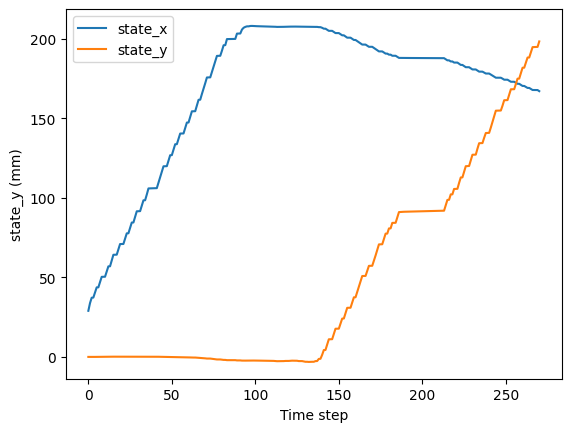

In [3]:
std_speed = np.std(speed_history[10:])
std_angular_speed = np.std(angular_speed_history[10:])
print("The speed variance in mm^2/s^2 is {}".format(std_speed))
print("The angular speed variance in rad^2/s^2 is {}".format(std_angular_speed))
print(len(speed_history))

# plt.plot(norm_distance[:], label="distance")
# plt.xlabel("Time step")
# plt.ylabel("distance (mm)")
# plt.legend()

# plt.plot(angle[:], label="angle")
# plt.xlabel("Time step")
# plt.ylabel("angle (deg)")
# plt.legend()

plt.plot(state_x[:], label="state_x")
plt.xlabel("Time step")
plt.ylabel("state_x (mm)")
plt.legend()

plt.plot(state_y[:], label="state_y")
plt.xlabel("Time step")
plt.ylabel("state_y (mm)")
plt.legend()

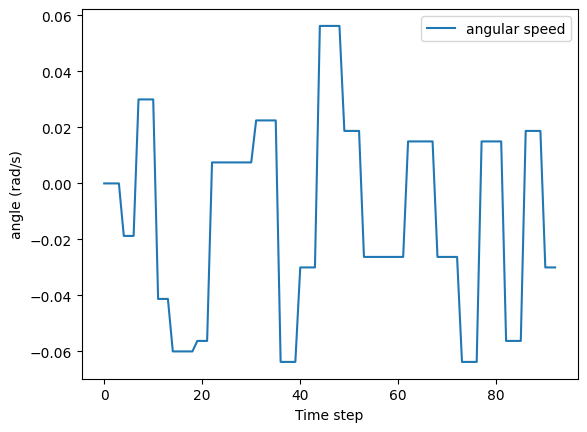

In [5]:
plt.plot(angular_speed_history[:], label="angular speed")
plt.xlabel("Time step")
plt.ylabel("angle (rad/s)")
plt.legend()